#1.Descrição do problema
O problema aqui é classificar imagens em tons de cinza de dígitos escritos à mão (28 ×28 pixels) em suas 10 categorias (0 a 9), assim, este é um problema de classificação multiclasse. Usaremos o conjunto de dados MNIST. É um conjunto de 60.000 imagens de treinamento, além de 10.000 imagens de teste, reunidas pelo Instituto Nacional de Padrões e Tecnologia (o NIST no MNIST).




#2.Importação de bibliotecas

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
import time
from keras.layers import GaussianNoise
import datetime
from mlxtend.plotting import plot_decision_regions
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Layer
from tensorflow.keras import models
from tensorflow.keras import layers

!pip install -q -U keras-tuner
import kerastuner as kt
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

     |████████████████████████████████| 71kB 5.1MB/s 


#3.Preparando os dados


## 3.1 Load dataset MNIST

O conjunto de dados MNIST vem pré-carregado no Keras, na forma de um conjunto de quatro matrizes NumPy. 
train_images e train_labels é do conjunto de treinamento. test_images e test_labels  são do conjunto de teste. Os labels são matrizes de dígitos, variando de 0 a 9. As imagens e os labels têm uma correspondência um para um.

In [ ]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


###3.1.1 Plot

Aí pode-se plotar qualquer imagem do dataset. Para trocar a imagem é só alterar o index.

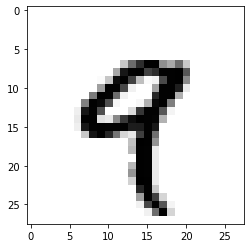

In [ ]:
index = 4
digit = train_images[index]
import matplotlib.pyplot as plt
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

###3.1.2 Dimensão dos tensores

As imagens geralmente têm três dimensões: altura, largura e profundidade de cor. Embora, em tons de cinza imagens (como nossos dígitos MNIST) têm apenas um único canal de cor e, portanto, podem ser armazenadas em tensores de classificação 2, mas por convenção, os tensores de imagem são sempre de classificação 3. Assim, os tensores train_images e test_images são da forma (6000, 28, 28, 1). Já os labels são tensores de dimensão 1.

In [ ]:
#Cada matriz numpy aqui é um tensor de dimensão 3 para train e test. Os labels são tensores de dimensão 1.
print(train_images.ndim)
print(train_images.shape)
print('\n')
print(test_images.ndim)
print(test_images.shape)
print('\n')
print(train_labels.ndim)
print(train_labels.shape)
print('\n')
print(test_labels.ndim)
print(test_labels.shape)



3
(60000, 28, 28)


3
(10000, 28, 28)


1
(60000,)


1
(10000,)


##3.2 Juntando e embaralhando o dataset

In [ ]:
# Juntando train_images e train_labels em um unico array
train_images = train_images.reshape((60000, 28 * 28))
train_labels = train_labels.reshape((60000, 1))

training_set = np.hstack((train_images,train_labels))
# print(train_images.shape)
# print(train_labels.shape)
# print(training_set.shape)
# print(training_set)

# Juntando test_images e test_labels em um unico array
test_images = test_images.reshape((10000, 28 * 28))
test_labels = test_labels.reshape((10000, 1))

test_set = np.hstack((test_images,test_labels))
# print(test_images.shape)
# print(test_labels.shape)
# print(test_set.shape)
# print(test_set)

# Juntando training_set e test_set em um unico array
dataset = np.vstack((training_set,test_set))
# print(training_set.shape)
# print(test_set.shape)
# print(dataset.shape)

# Embaralhando o dataset antes de dividi-lo
np.random.shuffle(dataset)

#print(test_images)

##3.3 Dividindo o dataset em train_set, dev_set e test_set


As proporções utilizadas são 80% para treinamento, 10% para validação e 10% para teste. Temos uma quantidade razoavelmente grande de dados e por isso utilizamos essas proporções.

Um modelo de aprendizado profundo nunca deve ser avaliado em seus dados de treinamento. Assim o "conjunto de validação", dev_set, será usado para monitorar a precisão do modelo durante o treinamento. É basicamente para monitorar em como o modelo se sai em novos dados.

In [ ]:
# Dividindo o dataset em training_set, dev_set e test_set
m = dataset.shape[0]
percent  = 0.80
m_linha  = int(np.floor(percent*m))
m_linha2 = int(np.floor(((1-percent)*m)/2))

## Traning set
train_images = dataset[0:m_linha,0:-1] # da primeira a penúltima coluna
train_labels = dataset[0:m_linha,-1]   # apenas a última coluna

## Dev set
dev_images = dataset[m_linha:(m_linha+m_linha2),0:-1]
dev_labels = dataset[m_linha:(m_linha+m_linha2),-1]

## Test set
test_images = dataset[(m_linha+m_linha2):,0:-1]
test_labels = dataset[(m_linha+m_linha2):,-1]

print(train_images.shape)
print(train_labels.shape)
print ('\n')
print(dev_images.shape)
print(dev_labels.shape)
print ('\n')
print(test_images.shape)
print(test_labels.shape)

(56000, 784)
(56000,)


(6999, 784)
(6999,)


(7001, 784)
(7001,)


##3.5 Novas dimensão dos tensores
Agora as linhas de cada matriz, train, dev e test, correspodem as imagens. Cada coluna corresponde aos pixels de cada imagem. Coluna 1 tem pixel 1 de cada imagem, coluna 2 tem pixel 2 da imagem 2 e assim por diante. Temos 784 colunas que são, justamente, 28*28 pixels. 

Os tensores agora tem dimensão 2 para train, dev e test. Continua tendo dimensão 1 para os labels que não foram alterados.

In [ ]:
print(train_images.ndim)
print('\n')
print(test_images.ndim)
print('\n')
print(dev_images.ndim)
print('\n')
print(train_labels.ndim)
print('\n')
print(dev_labels.ndim)
print('\n')
print(test_labels.ndim)


2


2


2


1


1


1


##3.4 Normalização (better learning)

Antes do treinamento, iremos pré-processar os dados remodelando-os para a forma que o modelo espera e dimensionando-o para que todos os valores estejam no intervalo ente [0, 1]. Anteriormente, nossas imagens de treinamento estavam em matrizes (60.000, 28, 28) com valores entre [0, 255]. Agora transformamos em uma matriz (56.000, 28 * 28) com valores entre 0 e 1.

Isso é feito pois não é seguro alimentar uma rede neural com dados que assumem valores relativamente grandes (por exemplo, valores que são muito maiores do que os valores iniciais dos pesos) ou dados que são heterogêneos. Isso pode desencadear grandes atualizações de gradiente que irão
impedir que a rede convirja.

In [ ]:
# Normalização
train_images = train_images.astype('float32') / 255
dev_images   = dev_images.astype('float32') / 255
test_images  = test_images.astype('float32') / 255

#4.Construindo o modelo

##4.1 Camadas e funções de ativação (better learning - *ReLU)

Decidimos usar um modelo de camadas sequenciais, uma atrás da outra e que são que são 'densamente conectadas', ou seja, todas as saídas de uma camada entram em cada neurônio da camada seguinte. As camadas basicamente extraem 'representações' dos dados que são mais significativas para o problema em questão. 


O modelo deve terminar com uma camada de 10 saídas ou vias (que é a dimensionalidade - quantidade de classes), o que significa que ele retornará uma matriz de 10 pontuações de probabilidade (onde o total soma 1). Cada pontuação será a probabilidade de que a imagem do dígito atual pertença a um dos 10 dígitos. Baseado nisso, como saída desta última camada utilizamos a função softmax, que também é um tipo de função sigmóide, mas é útil quando tentamos lidar com problemas de classificação que envolvem mais de duas classes, que é o nosso caso. A função softmax transforma as saídas para cada classe para valores entre 0 e 1 e também divide pela soma das saídas. Isso essencialmente dá a probabilidade de a entrada estar em uma determinada classe.

As camadas intermediárias devem ser suficientemente grandes, ou seja, não devem tem uma quantidade de neurônios muito menor do que a camada de saída. Nas saídas dessas camadas, exceto a última, utilizamos a função de ativação ReLU, que é uma das funções de ativação mais populares do aprendizado profundo, e destina-se a zerar os valores negativos. Assim, ela não ativa todos os neurônios ao mesmo tempo tornando a rede esparsa e eficiente, e de fácil computação.

Obs1: Sem uma função de ativação, a camada consistiria em duas operações lineares - um produto escalar e uma adição. Com uma função de ativação adiciona-se não-linearidades.





##4.2 Função de custo

É a quantidade que será minimizada durante o treinamento. Ela representa uma medida de sucesso para a tarefa em questão. Como nosso problema é de classificação envolvendo classes com números inteiros e predições de probabilidade entre 0 e 1, o ideal é utilizar 'sparse_categorical crossentropy', ela minimiza a distância entre as distribuições de probabilidade de saída do modelo e a verdadeira distribuição das labels. 

 Aprender, para uma rede neural, significa encontrar um conjunto de valores para os pesos do modelo que minimiza a função de custo.


##4.3 Otimizador (better learning)

É o mecanismo pelo qual o modelo se atualizará com base no dados de treinamento de modo a melhorar seu desempenho. 
 Determina como a rede será atualizada com base na função de custo. Isto implementa uma variante específica da descida gradiente estocástica (SGD). O otimizador 'rmsprop' é geralmente uma escolha boa o suficiente, seja qual for o problema, segundo  Chollet (2021, p. 113), e é o que estamos utiizando.

##4.4 Métrica para monitorar durante treinamento e teste
 Estamos usando como métrica a 'accuracy', é uma medida de sucesso do seu treinamento e validação.

##4.5 Batch Normalization (better learning)

Acelera o processo de aprendizagem reduzindo o número de períodos ou "epochs" necessários para o treinamento. O batch normalization foi utilizado antes da função de ativação (como mostrado no paper original sobre batch normalization).

##4.6 Regularização L2 (better generalization)
Faz com que a rede neural utilize pesos menores, o que a deixa mais estável e menos propensa ao sobreajuste (overfitting) ao realizar o dimensionamento do peso para que fique abaixo de um limite predefinido. Foi utilizada a norma L2 e o fator de regularização foi encontrado via Keras Tuner.

##4.7 Regularização usando ruído (better generalization)
Serve para melhorar a robustez da rede, melhorando a generalização e evitando que a rede decore os exemplos de treinamento, isso é feito através da adição de rúido durante o treinamento. Foi utilizado ruído gaussiano com fator de 0,1 testado empiricamente.

##4.8 O modelo e hiperparameter-tuning

Realizamos o ajuste de hiperparâmetros usando random search do keras tuner. Ele configura uma grade de valores de hiperparâmetros e selecionar combinações aleatórias para treinar o modelo e você define qual a métrica utilizada para a seleção final, como por exemplo, melhor acurácia, que foi o que utilizamos.

Para cada hiperparâmetro determinados uma faixa ou valores que o algoritmo "sorteou".




Hiperparâmetros que buscamos com hiperparameter tuning:

*  Número de neurônios da primeira camada ('units')
*  Taxa de aprendizagem ('learning rate')
*  Momento ('momentum')
*  Fator de regularização
*  Número de épocas 

Hiperparâmetros que fixamos:

*   Número de camadas
*   Número de neurônios da camada de saída









In [ ]:
def build_model(hp):

      model = keras.Sequential()
      
      #hiperparametros do modelo
      hp_units = hp.Int('units', min_value=300, max_value=340, step=32)
      hp_kernel_l2 = hp.Choice('kernel_regularizer', values=[1e-2, 1e-3, 1e-4,1e-5,1e-6,1e-7,1e-8,1e-9])
  
      model.add(layers.Dense(units= hp_units, kernel_regularizer=l2(hp_kernel_l2), kernel_initializer="he_uniform"))
      model.add(GaussianNoise(0.1))
      model.add(layers.BatchNormalization())
      model.add(layers.Activation(tf.nn.relu))

      model.add(layers.Dense(10, activation = tf.nn.softmax,kernel_initializer="he_uniform"))
 
      
      model.compile(
                optimizer=keras.optimizers.RMSprop(learning_rate = hp.Choice('learning_rate',
                          values=[1e-2, 1e-3, 1e-4]),momentum = hp.Choice('momentum',
                          values=[0.7,0.8,0.9])),
                loss ='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

      return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir5',
    project_name='helloworld5')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
tuner.search(train_images, train_labels,
             epochs=30,
             validation_data = (dev_images, dev_labels)
             )

Trial 3 Complete [00h 03m 07s]
val_accuracy: 0.9508501291275024

Best val_accuracy So Far: 0.9841405749320984
Total elapsed time: 00h 09m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#pega os hiperparâmetros ótimos
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, momentum is {best_hps.get('momentum')} and l2 is {best_hps.get('kernel_regularizer')}
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 332 and the optimal learning rate for the optimizer
is 0.0001, momentum is 0.9 and l2 is 1e-06



 Treinamento em busca do melhor número de épocas



O método fit implementa o loop de treinamento. Seus argumentos são:
 
*   Os dados de treinamento;
*   O número de épocas: quantas vezes o loop de treinamento deve iterar;
* O tamanho do lote a ser usado em cada época: o número de exemplos de treinamento considerados para calcular os gradientes para uma etapa de atualização de peso.

O treinamento aqui é feito usando o modelo com os hiperparametros adiquiridos anteriormente.

Depois encontramos o número ideal de épocas para treinar o modelo com os hiperparâmetros obtidos, usando um limite de 50 épocas.


In [ ]:
#treinando com o modelo
model = tuner.hypermodel.build(best_hps)

history = model.fit(
train_images, train_labels,
epochs=50,
batch_size=128,
validation_data = (dev_images, dev_labels))

# Encontre o número ideal de épocas para treinar o modelo com os hiperparâmetros obtidos na pesquisa.
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
438/438 [==============================] - 4s 8ms/step - loss: 0.4686 - accuracy: 0.8571 - val_loss: 0.1305 - val_accuracy: 0.9616
Epoch 2/50
438/438 [==============================] - 3s 7ms/step - loss: 0.1103 - accuracy: 0.9690 - val_loss: 0.0970 - val_accuracy: 0.9704
Epoch 3/50
438/438 [==============================] - 3s 7ms/step - loss: 0.0700 - accuracy: 0.9796 - val_loss: 0.0836 - val_accuracy: 0.9744
Epoch 4/50
438/438 [==============================] - 3s 7ms/step - loss: 0.0492 - accuracy: 0.9864 - val_loss: 0.0710 - val_accuracy: 0.9781
Epoch 5/50
438/438 [==============================] - 3s 7ms/step - loss: 0.0367 - accuracy: 0.9900 - val_loss: 0.0743 - val_accuracy: 0.9771
Epoch 6/50
438/438 [==============================] - 3s 7ms/step - loss: 0.0285 - accuracy: 0.9930 - val_loss: 0.0724 - val_accuracy: 0.9780
Epoch 7/50
438/438 [==============================] - 3s 7ms/step - loss: 0.0233 - accuracy: 0.9942 - val_loss: 0.0721 - val_accuracy: 0.9793
Epoch 

#5.Treinamento

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retreinando o modelo com o melhor número de épocas
hypermodel.fit(
train_images, train_labels,
epochs=best_epoch,
batch_size=128,
validation_data = (dev_images, dev_labels))

Epoch 1/45
438/438 [==============================] - 4s 8ms/step - loss: 0.4658 - accuracy: 0.8551 - val_loss: 0.1333 - val_accuracy: 0.9616
Epoch 2/45
438/438 [==============================] - 3s 7ms/step - loss: 0.1071 - accuracy: 0.9707 - val_loss: 0.0985 - val_accuracy: 0.9694
Epoch 3/45
438/438 [==============================] - 3s 7ms/step - loss: 0.0703 - accuracy: 0.9807 - val_loss: 0.0903 - val_accuracy: 0.9736
Epoch 4/45
438/438 [==============================] - 3s 7ms/step - loss: 0.0486 - accuracy: 0.9869 - val_loss: 0.0925 - val_accuracy: 0.9724
Epoch 5/45
438/438 [==============================] - 3s 7ms/step - loss: 0.0351 - accuracy: 0.9910 - val_loss: 0.0732 - val_accuracy: 0.9804
Epoch 6/45
438/438 [==============================] - 3s 7ms/step - loss: 0.0298 - accuracy: 0.9919 - val_loss: 0.0793 - val_accuracy: 0.9754
Epoch 7/45
438/438 [==============================] - 3s 7ms/step - loss: 0.0213 - accuracy: 0.9950 - val_loss: 0.0738 - val_accuracy: 0.9781
Epoch 

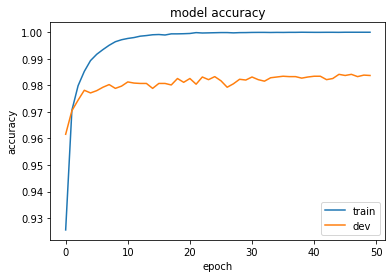

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

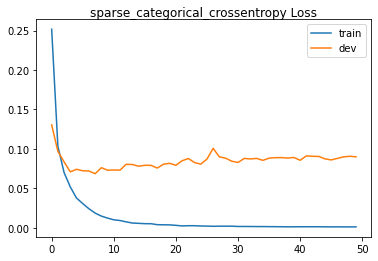

In [ ]:
plt.title('sparse_categorical_crossentropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()

#6.Aplicando o modelo aos dados de teste

Aqui recuperamos o modelo e aplicamos aos dados de teste.


In [ ]:
eval_result = hypermodel.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)

219/219 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.9830
[test loss, test accuracy]: [0.09396722912788391, 0.9830024242401123]


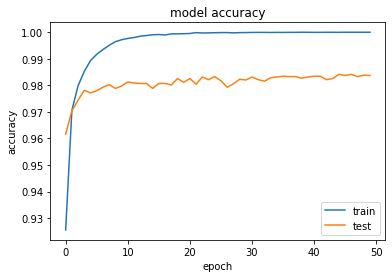

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#6.Comparação entre função de custo e métrica de train, dev e test



In [ ]:
loss_and_metrics = model.evaluate(train_images, train_labels, batch_size=128)

438/438 [==============================] - 1s 3ms/step - loss: 0.0012 - accuracy: 1.0000


In [ ]:
loss_and_metrics = model.evaluate(dev_images, dev_labels, batch_size=128)

55/55 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.9837


In [ ]:
loss_and_metrics = model.evaluate(test_images, test_labels, batch_size=128)

55/55 [==============================] - 0s 3ms/step - loss: 0.0992 - accuracy: 0.9824


#Referências

- [François Chollet. Deep Learning with Python, Second Edition, 2021.](https://www.manning.com/books/deep-learning-with-python-second-edition)

- https://keras.io/